# Instalar Tensorflow

In [ ]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from bs4 import BeautifulSoup # para trabajar texto en varios formatos
import re # expresiones regulares

#importar datos


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df= pd.read_csv("/content/drive/MyDrive/Magister/4° Semestre/Consultoria/Modelos de clasificacion previos/SMSSpamCollection(Filtrada).csv",sep= ";")

In [ ]:
df

,resultado,mensaje
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,spam,FreeMsg Hey there darling it's been 3 week's n...
2,ham,As per your request 'Melle Melle (Oru Minnamin...
3,spam,WINNER!! As a valued network customer you have...
4,spam,Had your mobile 11 months or more? U R entitle...
...,...,...
1285,spam,Had your contract mobile 11 Mnths? Latest Moto...
1286,ham,Yeh. Indians was nice. Tho it did kane me off ...
1287,spam,REMINDER FROM O2: To get 2.50 pounds free call...
1288,spam,This is the 2nd time we have tried 2 contact u...


#Análisis exploratorio

In [ ]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#funcion resumen de un dataframe

def resumen(data):
  total_perdidos = data.isnull().sum().sum()
  missing_percent = data.isnull().sum()*100 /len(data)
  total_missing = data.isnull().sum()
  unique = data.nunique()
  not_null = data.notnull().sum()
  df = pd.DataFrame({
      'Valores Unicos' : unique,
      'Valores Existentes': not_null,
      'Total perdidos': total_missing,
      'Porc. perdidos %': missing_percent
  })
  tipos = data.dtypes
  numericas = tipos[tipos != object].index
  no_numericas = tipos[tipos == object].index
  print('1. Las dimensiones de la data:', data.shape)
  print('2. Total Datos perdidos son:', total_perdidos)
  print('3. La cantidad de variables numericas es: ', len(numericas), '\n   Y ellas son:\n', numericas)
  print('4. La cantidad de variables NO numericas es: ', len(no_numericas), '\n  Y ellas son:\n', no_numericas)
  df = df.round(2)
  return(df)

In [ ]:
resumen(df)

1. Las dimensiones de la data: (1290, 2)
2. Total Datos perdidos son: 0
3. La cantidad de variables numericas es:  0 
   Y ellas son:
 Index([], dtype='object')
4. La cantidad de variables NO numericas es:  2 
  Y ellas son:
 Index(['resultado', 'mensaje'], dtype='object')


,Valores Unicos,Valores Existentes,Total perdidos,Porc. perdidos %
resultado,2,1290,0,0.0
mensaje,1148,1290,0,0.0


In [ ]:
df.groupby('resultado').size()

resultado
ham     668
spam    622
dtype: int64

ham     668
spam    622
Name: resultado, dtype: int64


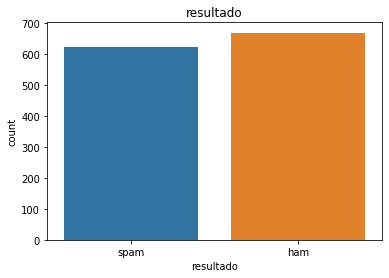

In [ ]:
sns.countplot(df['resultado'])
print(df['resultado'].value_counts())
plt.title("resultado")
plt.show()

In [ ]:
for i in df:
  print(i, len(df[i].unique()))

resultado 2
mensaje 1148


Debemos etiquetar a los textos convertidos a vectores

In [ ]:
df['resultado']

0       spam
1       spam
2        ham
3       spam
4       spam
        ... 
1285    spam
1286     ham
1287    spam
1288    spam
1289     ham
Name: resultado, Length: 1290, dtype: object

# Preprocesamiento de texto


In [ ]:
df

,resultado,mensaje
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,spam,FreeMsg Hey there darling it's been 3 week's n...
2,ham,As per your request 'Melle Melle (Oru Minnamin...
3,spam,WINNER!! As a valued network customer you have...
4,spam,Had your mobile 11 months or more? U R entitle...
...,...,...
1285,spam,Had your contract mobile 11 Mnths? Latest Moto...
1286,ham,Yeh. Indians was nice. Tho it did kane me off ...
1287,spam,REMINDER FROM O2: To get 2.50 pounds free call...
1288,spam,This is the 2nd time we have tried 2 contact u...


In [ ]:
df['resultado'] = df['resultado'].apply(lambda x:1 if x == 'ham' else 0) 

In [ ]:
df

,resultado,mensaje
0,0,Free entry in 2 a wkly comp to win FA Cup fina...
1,0,FreeMsg Hey there darling it's been 3 week's n...
2,1,As per your request 'Melle Melle (Oru Minnamin...
3,0,WINNER!! As a valued network customer you have...
4,0,Had your mobile 11 months or more? U R entitle...
...,...,...
1285,0,Had your contract mobile 11 Mnths? Latest Moto...
1286,1,Yeh. Indians was nice. Tho it did kane me off ...
1287,0,REMINDER FROM O2: To get 2.50 pounds free call...
1288,0,This is the 2nd time we have tried 2 contact u...


## Limpieza de datos

In [ ]:
# El código anterior me trae la última versión de keras
try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

from tensorflow.keras import layers # importar layers desde keras

import tensorflow_datasets as tfds # este me trae los tokens

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
def clean_tweet(tweet):

  tweet= BeautifulSoup(tweet,"lxml").get_text() # sirve para trabajar en un formato especial de tratar el texto. hay que usar el get_text para que me lo devuela en un formato legible
  
  # Dejamos todo en minúscula
  tweet = tweet.lower()
  # Reemplazamos puntos por espacios
  tweet = tweet.replace("."," ")
  # Eliminamos la @ y su mención
  tweet = re.sub(r"@[A-Za-z0-9.]+",' ',tweet) # después del @ puede leer lo que se encuentra en el []. El + significa. El r significa raw o string
  # Eliminamos los links de la URLs
  tweet = re.sub(r"https?://[A-Za-z0-9./]+",' ', tweet) # aqui el ? me dice que el caracter anterior puede estar o no
  # Nos quedamos solo con los caracteres
  tweet = re.sub(r"[^a-zA-Z.!?']",' ',tweet)# cualquier cosa que no sea lo que viene después de ^ se va a sustituir por espacios en blanco
  # Eliminamos los sitios web
  tweet = re.sub(r"www[A-Za-z0-9./]+",' ', tweet)
  # Eliminamos espacios en blanco adicionales
  tweet = re.sub(r" +",' ',tweet)# si existe más de un espacio en blanco lo reemplazamos por uno solo. El más me dice eso, si hay más de uno reemplazo
  return tweet

In [ ]:
df_clean = [clean_tweet(tweet) for tweet in df.mensaje] # esto me queda en una lista guardado

# transformar texto (Embedding)

In [ ]:
# 4to paso: Vamos a crear dos variables que cargaran en memoria dos funciones para transformar el texto
##
##   - preprocessor: "objeto" que se encargará de transformar el texto en el formato que necesita el modelo BERT para funcionar
##   - encoder: "objeto" que será el modelo BERT y se alimentará del resultado de preprocessor, retornando el texto transformado en un vector numérico.

preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.load("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2")

In [ ]:
# 5to paso: Vamos a usar el objeto preprocessor, y guardamos su resultado en la variable embedding
##   A modo de ejemplo para su revisión, solo vamos a transformar dos textos:

embedding = preprocessor(df_clean) # df_clean es el texto

In [ ]:
# 6to paso: Vamos a codificar el texto con el modelo BERT:
##   - Fijarse que el objeto encoder recibe como argumento la variable embedding (resultado de preprocessor)
##   - Copiar el siguiente código de forma literal

pooled_output = encoder(embedding)["pooled_output"]

In [ ]:
# Opcional: revisamos el contenido de la variable pooled_output, el cual tiene dos vectores de 128 dimensiones
##
##    - Dos vectores, porque le pasamos solo dos textos
##    - 128 dimensiones, porque el modelo BERT utilizado convierte cualquier texto (independiente del largo) en un vector numérico de 128 dimensiones.

pooled_output

<tf.Tensor: shape=(1290, 128), dtype=float32, numpy=
array([[-0.999942  , -0.00141432, -0.9810854 , ...,  0.98082685,
         0.98178196,  0.96391606],
       [-0.9991202 ,  0.05296545, -0.98559695, ...,  0.9239925 ,
         0.9558225 ,  0.9984839 ],
       [-0.99986243,  0.03978845, -0.9731644 , ...,  0.73242617,
         0.97078604,  0.9766909 ],
       ...,
       [-0.99998385,  0.03318281, -0.9955043 , ...,  0.95926076,
         0.9974624 ,  0.96427304],
       [-0.9999856 ,  0.1223898 , -0.9896996 , ...,  0.98565143,
         0.96824807,  0.9937904 ],
       [-0.9996448 ,  0.09184256, -0.9976637 , ...,  0.90646094,
         0.9652779 ,  0.99890375]], dtype=float32)>

In [ ]:
# 7mo paso: El contenido de la variable pooled_output es una estructura de datos de tipo tensorflow.
#           Para transformarlo a un dataframe y usarlo de forma tradicional con los modelos clásicos, 
#           ejecutamos la siguiente linea de código:

dataX2 = pd.DataFrame(pooled_output.numpy())

In [ ]:
# Opcional:  Ahora la variable dataX es un dataframe y podemos revisar su dimensionalidad y visualizarlo:
dataX2.shape

(1290, 128)

In [ ]:
dataX2

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.999942,-0.001414,-0.981085,-0.484473,-0.948341,0.171350,-0.981562,-0.706304,-0.006808,-0.095359,...,0.128026,-0.990112,0.187941,-0.998624,-0.819512,0.877467,-0.999149,0.980827,0.981782,0.963916
1,-0.999120,0.052965,-0.985597,0.318218,-0.978574,-0.563376,-0.998118,0.185895,0.121993,0.005437,...,0.155417,-0.251321,0.236179,-0.999170,-0.642842,0.981704,-0.992995,0.923993,0.955823,0.998484
2,-0.999862,0.039788,-0.973164,0.168508,-0.969527,-0.213720,-0.988347,-0.972103,-0.031048,-0.025507,...,0.133916,-0.986624,0.169207,-0.999534,-0.628558,0.798255,-0.977197,0.732426,0.970786,0.976691
3,-0.999984,0.044671,-0.993844,0.591809,-0.880615,0.781171,-0.973504,-0.696313,0.135529,-0.005958,...,0.142242,-0.995556,0.196146,-0.998720,-0.586202,0.946417,-0.997387,0.998785,0.998541,0.884596
4,-0.999940,0.095895,-0.997162,-0.121784,-0.996297,0.846379,-0.994946,0.436924,0.035794,-0.006821,...,0.215716,-0.989526,0.178496,-0.999673,-0.879214,0.881079,-0.998047,0.986704,0.997149,0.974610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,-0.999978,0.044769,-0.996063,0.206673,-0.993597,0.577214,-0.994746,0.505085,0.094988,0.063025,...,0.203866,-0.998053,0.137735,-0.999817,-0.956234,0.923886,-0.996958,0.989620,0.994490,0.967436
1286,-0.999188,0.034496,-0.990960,0.951374,-0.999831,-0.388626,-0.997586,0.758842,0.070556,0.052468,...,0.134165,-0.782383,0.201555,-0.999390,-0.920580,0.792196,-0.945352,0.811551,0.946749,0.997387
1287,-0.999984,0.033183,-0.995504,0.454196,-0.921501,-0.103736,-0.989906,-0.962311,-0.030409,-0.049869,...,0.104561,-0.996887,0.170619,-0.999599,-0.375127,0.962274,-0.997076,0.959261,0.997462,0.964273
1288,-0.999986,0.122390,-0.989700,0.519770,-0.975490,0.565476,-0.979562,-0.951744,0.093162,-0.001901,...,0.189051,-0.991586,0.195924,-0.999426,-0.709937,0.916501,-0.998173,0.985651,0.968248,0.993790


#seleccion de las variable

In [ ]:
X = dataX2 
Y = df['resultado'].copy()

In [ ]:
X.columns

RangeIndex(start=0, stop=128, step=1)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Columns: 128 entries, 0 to 127
dtypes: float32(128)
memory usage: 645.1 KB


In [ ]:
Y.head()

0    0
1    0
2    1
3    0
4    0
Name: resultado, dtype: int64

# Balanceo de datos

## Aplicando Smote

In [ ]:
from imblearn.over_sampling import SMOTE #over sobre nivelar hacia arriba under nivelacion hacia el menor dato
#from imblearn.under_sampling import SMOTE 

smote = SMOTE(random_state = 325, n_jobs=-1)
X_smote, Y_smote = smote.fit_resample(X, Y)# hace Balance de los datos a partir de los agreglos

from collections import Counter

Counter(Y_smote)

Counter({0: 668, 1: 668})

# Train y test

In [ ]:
from sklearn.model_selection import train_test_split
X_train_smote, X_test_smote, Y_train_smote, Y_test_smote = train_test_split(X_smote, Y_smote, random_state=325,test_size = 0.3)
        
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=325,test_size = 0.3)        

# SVM


##SVC 

### Caso 1

In [ ]:
parametros = {'C'      : np.arange(1, 5, 1),
            'gamma'  : np.arange(1, 5, 1),
           'kernel' : ['rbf', 'linear','sigmoid']}

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf = SVC(class_weight='balanced', random_state=325)  
grid_search = GridSearchCV(clf, parametros, n_jobs=-1, cv=5) 

In [ ]:
grid_search.fit(X_train_smote, Y_train_smote)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=325),
             n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4]), 'gamma': array([1, 2, 3, 4]),
                         'kernel': ['rbf', 'linear', 'sigmoid']})

In [ ]:
print('El mejor modelo:\n', grid_search.best_params_)

El mejor modelo:
 {'C': 2, 'gamma': 1, 'kernel': 'linear'}


In [ ]:
clf_best = grid_search.best_estimator_
pred = clf_best.predict(X_test_smote)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_smote, pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       212
           1       0.93      0.92      0.92       189

    accuracy                           0.93       401
   macro avg       0.93      0.92      0.92       401
weighted avg       0.93      0.93      0.93       401



Matriz de Confusión
[[198  14]
 [ 16 173]]


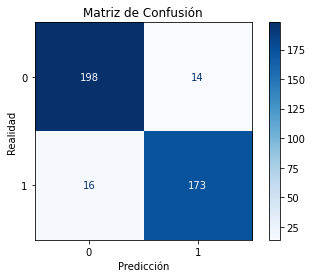

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay.from_estimator(
       clf_best,
       X_test_smote,
       Y_test_smote,
       display_labels=None,
       cmap=plt.cm.Blues,
       normalize=None)

disp.ax_.set_title('Matriz de Confusión')
disp.ax_.set_xlabel('Predicción');
disp.ax_.set_ylabel('Realidad'); 
disp.ax_.xaxis.set_ticklabels(['0', '1']); 
disp.ax_.yaxis.set_ticklabels(['0', '1']);

print('Matriz de Confusión')
print(disp.confusion_matrix)

plt.show()

## Nusvm

### Caso 1

In [ ]:
parametros = {'nu'      : np.arange(0, 1, 0.1),
            'gamma'  : ['scale','auto'],
           'kernel' : ['rbf', 'linear','sigmoid']}

from sklearn.svm import NuSVC
from sklearn.model_selection import GridSearchCV

clf = NuSVC(class_weight='balanced', random_state=325)  
grid_search = GridSearchCV(clf, parametros, n_jobs=-1, cv=5) 

In [ ]:
grid_search.fit(X_train_smote, Y_train_smote)

GridSearchCV(cv=5, estimator=NuSVC(class_weight='balanced', random_state=325),
             n_jobs=-1,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'sigmoid'],
                         'nu': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [ ]:
print('El mejor modelo:\n', grid_search.best_params_)

El mejor modelo:
 {'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.1}


In [ ]:
clf_best = grid_search.best_estimator_
pred = clf_best.predict(X_test_smote)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test_smote, pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       212
           1       0.95      0.93      0.94       189

    accuracy                           0.94       401
   macro avg       0.94      0.94      0.94       401
weighted avg       0.94      0.94      0.94       401



Matriz de Confusión
[[202  10]
 [ 13 176]]


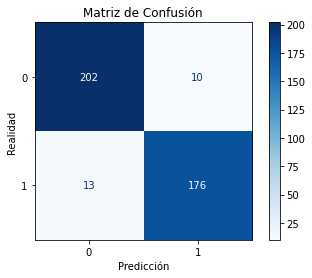

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay.from_estimator(
       clf_best,
       X_test_smote,
       Y_test_smote,
       display_labels=None,
       cmap=plt.cm.Blues,
       normalize=None)

disp.ax_.set_title('Matriz de Confusión')
disp.ax_.set_xlabel('Predicción');
disp.ax_.set_ylabel('Realidad'); 
disp.ax_.xaxis.set_ticklabels(['0', '1']); 
disp.ax_.yaxis.set_ticklabels(['0', '1']);

print('Matriz de Confusión')
print(disp.confusion_matrix)

plt.show()

#SECCION CON DATOS SIN PREPROCESAR

# transformar texto(Embeding) Sin preprocesamiento de texto

In [ ]:
df

,resultado,mensaje
0,0,Free entry in 2 a wkly comp to win FA Cup fina...
1,0,FreeMsg Hey there darling it's been 3 week's n...
2,1,As per your request 'Melle Melle (Oru Minnamin...
3,0,WINNER!! As a valued network customer you have...
4,0,Had your mobile 11 months or more? U R entitle...
...,...,...
1285,0,Had your contract mobile 11 Mnths? Latest Moto...
1286,1,Yeh. Indians was nice. Tho it did kane me off ...
1287,0,REMINDER FROM O2: To get 2.50 pounds free call...
1288,0,This is the 2nd time we have tried 2 contact u...


In [ ]:
# 4to paso: Vamos a crear dos variables que cargaran en memoria dos funciones para transformar el texto
##
##   - preprocessor: "objeto" que se encargará de transformar el texto en el formato que necesita el modelo BERT para funcionar
##   - encoder: "objeto" que será el modelo BERT y se alimentará del resultado de preprocessor, retornando el texto transformado en un vector numérico.

preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.load("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2")

In [ ]:
# 5to paso: Vamos a usar el objeto preprocessor, y guardamos su resultado en la variable embedding
##   A modo de ejemplo para su revisión, solo vamos a transformar dos textos:

embedding = preprocessor(df['mensaje']) # df['mensaje'] es el texto

In [ ]:
# 6to paso: Vamos a codificar el texto con el modelo BERT:
##   - Fijarse que el objeto encoder recibe como argumento la variable embedding (resultado de preprocessor)
##   - Copiar el siguiente código de forma literal

pooled_output = encoder(embedding)["pooled_output"]

In [ ]:
# Opcional: revisamos el contenido de la variable pooled_output, el cual tiene dos vectores de 128 dimensiones
##
##    - Dos vectores, porque le pasamos solo dos textos
##    - 128 dimensiones, porque el modelo BERT utilizado convierte cualquier texto (independiente del largo) en un vector numérico de 128 dimensiones.

pooled_output

<tf.Tensor: shape=(1290, 128), dtype=float32, numpy=
array([[-0.9999836 ,  0.01233948, -0.97867   , ...,  0.973742  ,
         0.8694874 ,  0.92939764],
       [-0.99979466,  0.05645132, -0.9942094 , ...,  0.8997836 ,
         0.8589003 ,  0.99508   ],
       [-0.99994373,  0.02813301, -0.9845494 , ...,  0.7336781 ,
         0.9590306 ,  0.9695843 ],
       ...,
       [-0.9999937 ,  0.05234575, -0.9969019 , ...,  0.9701582 ,
         0.9953039 ,  0.93751097],
       [-0.9999974 ,  0.08623969, -0.9962204 , ...,  0.9832028 ,
         0.6856057 ,  0.94771725],
       [-0.9996448 ,  0.09184256, -0.9976637 , ...,  0.90646094,
         0.9652779 ,  0.99890375]], dtype=float32)>

In [ ]:
# 7mo paso: El contenido de la variable pooled_output es una estructura de datos de tipo tensorflow.
#           Para transformarlo a un dataframe y usarlo de forma tradicional con los modelos clásicos, 
#           ejecutamos la siguiente linea de código:

dataX2 = pd.DataFrame(pooled_output.numpy())

In [ ]:
# Opcional:  Ahora la variable dataX es un dataframe y podemos revisar su dimensionalidad y visualizarlo:
dataX2.shape

(1290, 128)

In [ ]:
dataX2

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.999984,0.012339,-0.978670,-0.390501,-0.916917,0.785426,-0.960855,-0.899993,-0.026774,0.006909,...,0.102973,-0.997656,0.131492,-0.999817,-0.885076,0.849013,-0.998878,0.973742,0.869487,0.929398
1,-0.999795,0.056451,-0.994209,0.063637,-0.976721,-0.259604,-0.996063,0.210839,0.120435,0.046410,...,0.136751,-0.518643,0.198305,-0.999841,-0.667421,0.978685,-0.995415,0.899784,0.858900,0.995080
2,-0.999944,0.028133,-0.984549,0.188969,-0.981058,-0.075677,-0.987081,-0.971607,-0.040403,-0.020766,...,0.121796,-0.987217,0.160352,-0.999855,-0.689945,0.858107,-0.990487,0.733678,0.959031,0.969584
3,-0.999998,0.087004,-0.998042,0.028922,-0.895981,0.884447,-0.944886,-0.877754,0.108473,0.004284,...,0.142328,-0.998706,0.098014,-0.999967,-0.565350,0.954452,-0.998851,0.997118,0.963491,0.777209
4,-0.999968,0.092309,-0.991751,-0.398493,-0.989488,0.908049,-0.992710,0.105460,0.048611,-0.012153,...,0.218415,-0.997700,0.167798,-0.999842,-0.863140,0.947459,-0.997234,0.991300,0.993118,0.958039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,-0.999991,0.060197,-0.999659,0.075845,-0.996350,0.716204,-0.992615,0.528149,0.107021,-0.010136,...,0.220872,-0.996582,0.114361,-0.999985,-0.912078,0.941813,-0.999059,0.975390,0.980778,0.920063
1286,-0.999953,0.030791,-0.999822,0.927945,-0.999750,-0.179566,-0.987749,0.726748,0.090772,0.035918,...,0.108623,-0.716046,0.121274,-0.999976,-0.861851,0.668276,-0.994187,0.888636,0.890242,0.972008
1287,-0.999994,0.052346,-0.996902,0.245643,-0.920715,0.041507,-0.978795,-0.972810,-0.000673,-0.063252,...,0.127478,-0.997758,0.113584,-0.999896,-0.482480,0.967473,-0.997917,0.970158,0.995304,0.937511
1288,-0.999997,0.086240,-0.996220,0.014216,-0.955859,0.794546,-0.974418,-0.943467,0.073484,0.030729,...,0.147318,-0.997681,0.099959,-0.999969,-0.603682,0.850176,-0.999193,0.983203,0.685606,0.947717


#seleccion de las variable

In [ ]:
X = dataX2 
Y = df['resultado'].copy()

In [ ]:
X.columns

RangeIndex(start=0, stop=128, step=1)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Columns: 128 entries, 0 to 127
dtypes: float32(128)
memory usage: 645.1 KB


In [ ]:
Y.head()

0    0
1    0
2    1
3    0
4    0
Name: resultado, dtype: int64

# Balanceo de datos

## Aplicando Smote

In [ ]:
from imblearn.over_sampling import SMOTE #over sobre nivelar hacia arriba under nivelacion hacia el menor dato
#from imblearn.under_sampling import SMOTE 

smote = SMOTE(random_state = 325, n_jobs=-1)
X_smote, Y_smote = smote.fit_resample(X, Y)# hace Balance de los datos a partir de los agreglos

from collections import Counter

Counter(Y_smote)

Counter({0: 668, 1: 668})

# Train y test

In [ ]:
from sklearn.model_selection import train_test_split
X_train_smote, X_test_smote, Y_train_smote, Y_test_smote = train_test_split(X_smote, Y_smote, random_state=325,test_size = 0.3)
        
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=325,test_size = 0.3)        

# SVM


##SVC 

### Caso 1

In [ ]:
parametros = {'C'      : np.arange(1, 5, 1),
            'gamma'  : np.arange(1, 5, 1),
           'kernel' : ['rbf', 'linear','sigmoid']}

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf = SVC(class_weight='balanced', random_state=325)  
grid_search = GridSearchCV(clf, parametros, n_jobs=-1, cv=5) 

In [ ]:
grid_search.fit(X_train_smote, Y_train_smote)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=325),
             n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4]), 'gamma': array([1, 2, 3, 4]),
                         'kernel': ['rbf', 'linear', 'sigmoid']})

In [ ]:
print('El mejor modelo:\n', grid_search.best_params_)

El mejor modelo:
 {'C': 1, 'gamma': 1, 'kernel': 'linear'}


In [ ]:
clf_best = grid_search.best_estimator_
pred = clf_best.predict(X_test_smote)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_smote, pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       212
           1       0.96      0.95      0.95       189

    accuracy                           0.96       401
   macro avg       0.96      0.96      0.96       401
weighted avg       0.96      0.96      0.96       401



Matriz de Confusión
[[204   8]
 [  9 180]]


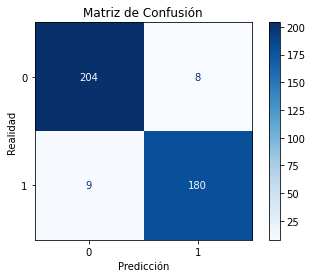

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay.from_estimator(
       clf_best,
       X_test_smote,
       Y_test_smote,
       display_labels=None,
       cmap=plt.cm.Blues,
       normalize=None)

disp.ax_.set_title('Matriz de Confusión')
disp.ax_.set_xlabel('Predicción');
disp.ax_.set_ylabel('Realidad'); 
disp.ax_.xaxis.set_ticklabels(['0', '1']); 
disp.ax_.yaxis.set_ticklabels(['0', '1']);

print('Matriz de Confusión')
print(disp.confusion_matrix)

plt.show()

## Nusvm

### Caso 1

In [ ]:
parametros = {'nu'      : np.arange(0, 1, 0.1),
            'gamma'  : ['scale','auto'],
           'kernel' : ['rbf', 'linear','sigmoid']}

from sklearn.svm import NuSVC
from sklearn.model_selection import GridSearchCV

clf = NuSVC(class_weight='balanced', random_state=325)  
grid_search = GridSearchCV(clf, parametros, n_jobs=-1, cv=5) 

In [ ]:
grid_search.fit(X_train_smote, Y_train_smote)

GridSearchCV(cv=5, estimator=NuSVC(class_weight='balanced', random_state=325),
             n_jobs=-1,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'sigmoid'],
                         'nu': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [ ]:
print('El mejor modelo:\n', grid_search.best_params_)

El mejor modelo:
 {'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.1}


In [ ]:
clf_best = grid_search.best_estimator_
pred = clf_best.predict(X_test_smote)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test_smote, pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       212
           1       0.93      0.97      0.95       189

    accuracy                           0.95       401
   macro avg       0.95      0.95      0.95       401
weighted avg       0.95      0.95      0.95       401



Matriz de Confusión
[[199  13]
 [  6 183]]


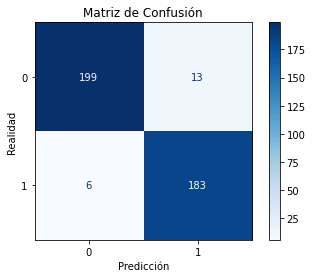

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay.from_estimator(
       clf_best,
       X_test_smote,
       Y_test_smote,
       display_labels=None,
       cmap=plt.cm.Blues,
       normalize=None)

disp.ax_.set_title('Matriz de Confusión')
disp.ax_.set_xlabel('Predicción');
disp.ax_.set_ylabel('Realidad'); 
disp.ax_.xaxis.set_ticklabels(['0', '1']); 
disp.ax_.yaxis.set_ticklabels(['0', '1']);

print('Matriz de Confusión')
print(disp.confusion_matrix)

plt.show()